Импорт

In [3]:
import pandas as pd
import re
from keras.models import Sequential
from keras import layers
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn import metrics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DNS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Оброботка данных под модель

In [4]:
data = pd.read_csv('csv_data\\cleaned_dataset.csv')
X = data['Review']
Y = data['Sentiment']

In [5]:
data.head(10)

,Sentiment,Review
0,1,stuff go moment mj ive start listen music watc...
1,1,classic war world timothy hines entertain film...
2,0,film start manager nicholas bell give welcome ...
3,0,must assume praise film greatest film opera ev...
4,1,superbly trashy wondrously unpretentious 80 ex...
5,1,dont know people think bad movie get pretty go...
6,0,movie could good come way short cheesy special...
7,0,watch video friend house im glad waste money b...
8,0,friend mine buy film 1 even wa grossly overpri...
9,1,movie full reference like mad max ii wild one ...


In [6]:
data.Review.apply(lambda x: len(x.split(" "))).mean()

130.08400115863668

In [10]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1 

In [ ]:
import json
import keras
import io
# saving
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# loading
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer_load = keras.preprocessing.text.tokenizer_from_json(data)

In [5]:
import json
import keras
import io
with open('review-predictor\\tokenizer.json') as f:
    data = json.load(f)
    tokenizer_load = keras.preprocessing.text.tokenizer_from_json(data)
for word in ['movie', 'film', 'director', 'actor']:
    print('{}: {}'.format(word, tokenizer_load.word_index[word]))

movie: 1
film: 3
director: 68
actor: 54


In [11]:
maxlen = 130

X = pad_sequences(X, padding='post', maxlen=maxlen)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

Подготовка "embedding" матрицы

In [10]:
import io
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with io.open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove\glove300d.txt', tokenizer.word_index, embedding_dim)

Модель

In [13]:


model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.Conv1D(130, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dropout(0.10))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 100)          18769100  
                                                                 
 conv1d (Conv1D)             (None, 126, 130)          65130     
                                                                 
 global_max_pooling1d (Glob  (None, 130)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 20)                2620      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                        

In [12]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/3
498/498 [==============================] - 155s 308ms/step - loss: 0.4069 - accuracy: 0.8105 - val_loss: 0.2798 - val_accuracy: 0.8850
Epoch 2/3
498/498 [==============================] - 153s 306ms/step - loss: 0.2137 - accuracy: 0.9196 - val_loss: 0.2394 - val_accuracy: 0.9076
Epoch 3/3
498/498 [==============================] - 158s 317ms/step - loss: 0.1148 - accuracy: 0.9632 - val_loss: 0.2378 - val_accuracy: 0.9162
Training Accuracy: 0.9915
Testing Accuracy:  0.9162


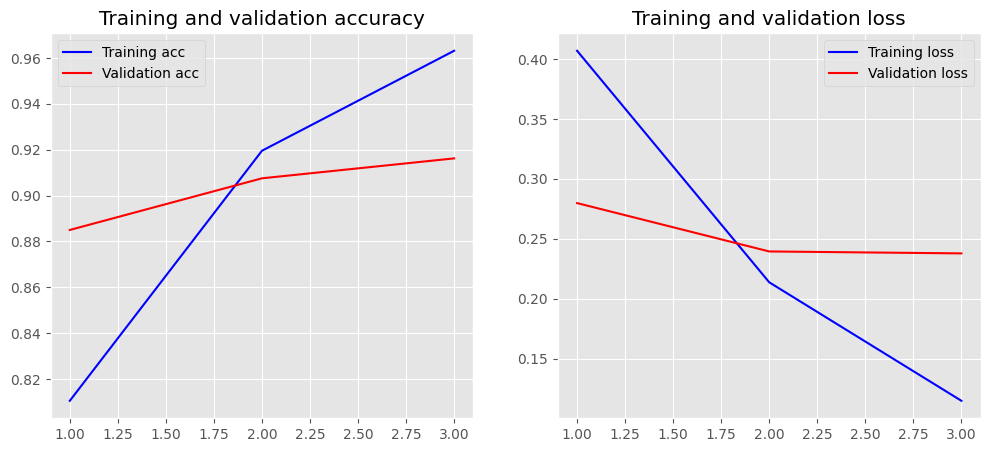

In [14]:
history = model.fit(x_train, y_train,
                    epochs=3,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    batch_size=100)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


In [15]:
model.save('convmodel.keras')

In [16]:
from keras.backend import clear_session
clear_session()

In [1]:
import keras

389/389 [==============================] - 3s 7ms/step


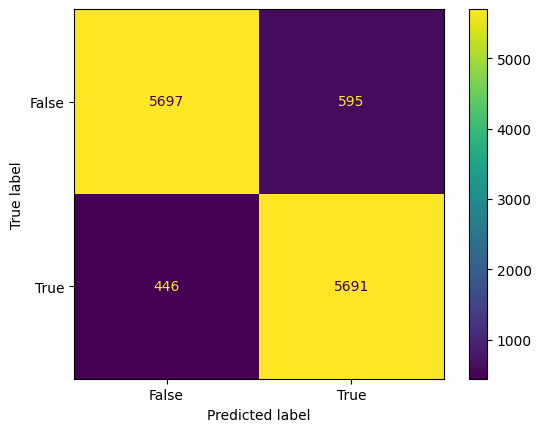

In [13]:
loaded_model = keras.models.load_model('convmodel.keras')
pred = loaded_model.predict([x_test])
pred = pred.round()
pred = [x[0] for x in pred]
cm = metrics.confusion_matrix(y_test,pred)
 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = [False, True])
 
cm_display.plot()
plt.show()